In [2]:
import pandas as pd 
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

In [4]:
def function_all(df):
    f1 = process_missing(df)
    f2 = process_age(f1)
    f3 = process_fare(f2)
    f4 = process_titles(f3)
    f5 = process_cabin(f4)
    f5 = create_dummies(f5,"Age_categories")
    f5 = create_dummies(f5,"Fare_categories")
    f5 = create_dummies(f5,"Title")
    f5 = create_dummies(f5,"Cabin_type")
    f5 = create_dummies(f5,"Sex")
    return f5
    

In [5]:
train = function_all(train)
holdout = function_all(holdout)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

train['SibSp'].describe()
train['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

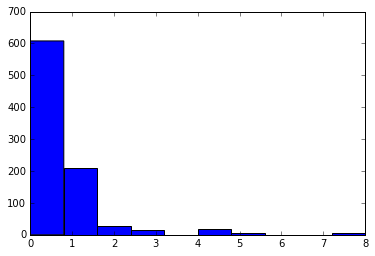

In [16]:
plt.hist(train['SibSp'])
plt.show()

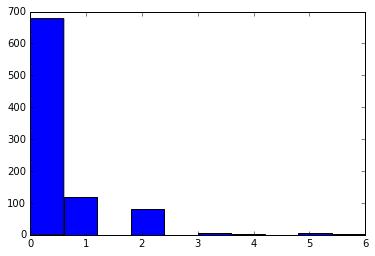

In [17]:
plt.hist(train['Parch'])
plt.show()

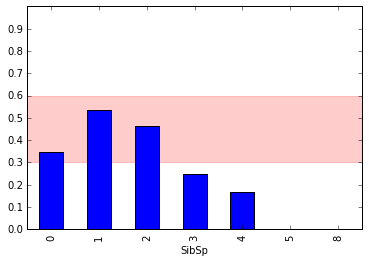

In [21]:
import numpy as np
x = train.pivot_table(index = "SibSp", values = "Survived")
plt.axhspan(.3, .6, alpha=0.2, color='red')
x.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

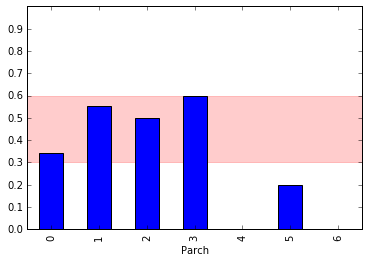

In [22]:
import numpy as np
x = train.pivot_table(index = "Parch", values = "Survived")
plt.axhspan(.3, .6, alpha=0.2, color='red')
x.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [23]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'p': 1, 'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4, 'max_features': 'log2'}



In [25]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)

NameError: name 'result' is not defined